### Esercitazione 29 - FBProphet e la predizione tramite l'analisi di Cicli

I cicli del mercato azionario sono associabili a dei modelli di prezzo a lungo termine dei mercati
e sono spesso associati a cicli economici generali.    
Sono fondamentali nell'analisi tecnica basata sull'analisi di cicli o di modelli di
prezzo ripetuti.     
Avendo una migliore comprensione dei cicli del mercato azionario, si potrebbe sempre
acquistare a un prezzo relativamente basso e vendere a un prezzo relativamente alto
in ogni ciclo, riscontrando un rendimento sempre positivo.     
       
La libreria FBProphet è utile per analizzare a fondo i cicli nascosti del mercato.      
FBProphet è una libreria open source rilasciata da Facebook per fornire alcune indicazioni
utili a produrre previsioni. Per impostazione predefinita, divide una serie temporale in
trend e stagionalità su base annuale, settimanale e giornaliera. E' possibile comunque
definire la propria stagionalità.         
Una delle caratteristiche di questa libreria è la sua semplicità e flessibilità.          
Poiché i cicli del mercato azionario che vogliamo capire non sono limitati ad annuali,
settimanali o giornalieri, dovremmo definire i nostri cicli e scoprire quali possono
adattarsi meglio ai dati.

In [31]:
from prophet import Prophet  # pip install prophet
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

candele_simulazione = 365 * 3
simbolo = 'BTCUSD'

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos(simbolo, mt5.TIMEFRAME_D1, 0, candele_simulazione))
    candles['time'] = pd.to_datetime(candles['time'], unit='s')
    candles.set_index('time', inplace=True)

    mt5.shutdown()
else:
    print('MT5 account error.')

In [33]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.add_seasonality(
    'intervallo_custom', # nome
    period=5, # giorni del periodo custom
    fourier_order=3, # numero delle componenti della trasformata di Fourier da considerare
    mode='additive'
)

c = candles.copy()
c['ds'] = c.index
c['y'] = c.close
c = c[['ds', 'y']]

giorni_previsione = 60
train_candles = c.iloc[:-giorni_previsione]
test_candles = c.iloc[-giorni_previsione:]

m.fit(train_candles)

10:58:40 - cmdstanpy - INFO - Chain [1] start processing
10:58:40 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = m.make_future_dataframe(periods=giorni_previsione)

print(future.head())

print(future.tail())

          ds
0 2019-06-19
1 2019-06-20
2 2019-06-21
3 2019-06-23
4 2019-06-24
             ds
1090 2022-12-05
1091 2022-12-06
1092 2022-12-07
1093 2022-12-08
1094 2022-12-09


In [35]:
print(train_candles.head())

print(train_candles.tail())

                   ds         y
time                           
2019-06-19 2019-06-19   9220.75
2019-06-20 2019-06-20   9507.24
2019-06-21 2019-06-21   9921.75
2019-06-23 2019-06-23  10868.74
2019-06-24 2019-06-24  10912.00
                   ds        y
time                          
2022-10-05 2022-10-05  20048.2
2022-10-06 2022-10-06  19907.0
2022-10-07 2022-10-07  19536.4
2022-10-09 2022-10-09  19474.6
2022-10-10 2022-10-10  19234.4


In [36]:
forecast = m.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,intervallo_custom,intervallo_custom_lower,intervallo_custom_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-19,10099.413747,4641.816239,15943.852275,10099.413747,10099.413747,6.232860,6.232860,6.232860,6.232860,6.232860,6.232860,0.0,0.0,0.0,10105.646607
1,2019-06-20,10091.325973,4480.414549,16047.810371,10091.325973,10091.325973,94.099484,94.099484,94.099484,94.099484,94.099484,94.099484,0.0,0.0,0.0,10185.425456
2,2019-06-21,10083.238198,4259.974340,15606.289212,10083.238198,10083.238198,-120.891773,-120.891773,-120.891773,-120.891773,-120.891773,-120.891773,0.0,0.0,0.0,9962.346425
3,2019-06-23,10067.062649,4800.432730,15694.259698,10067.062649,10067.062649,79.339358,79.339358,79.339358,79.339358,79.339358,79.339358,0.0,0.0,0.0,10146.402007
4,2019-06-24,10058.974875,4226.091252,15765.425023,10058.974875,10058.974875,6.232860,6.232860,6.232860,6.232860,6.232860,6.232860,0.0,0.0,0.0,10065.207735


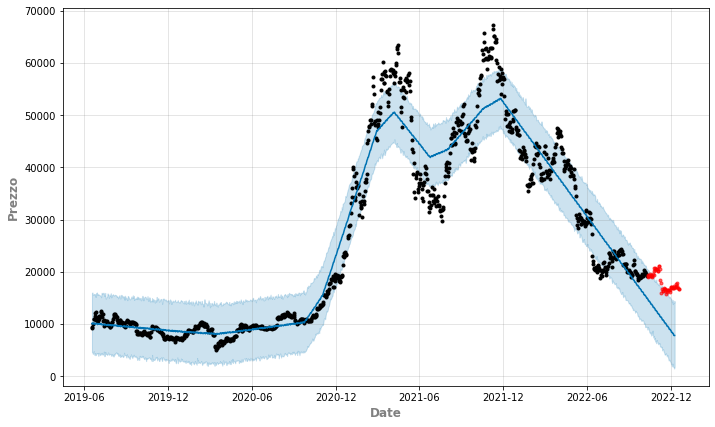

In [37]:
m.plot(forecast)
plt.plot(test_candles.y, '.', color='red', alpha=0.6)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Prezzo', fontsize=12, fontweight='bold', color='gray')
plt.show()

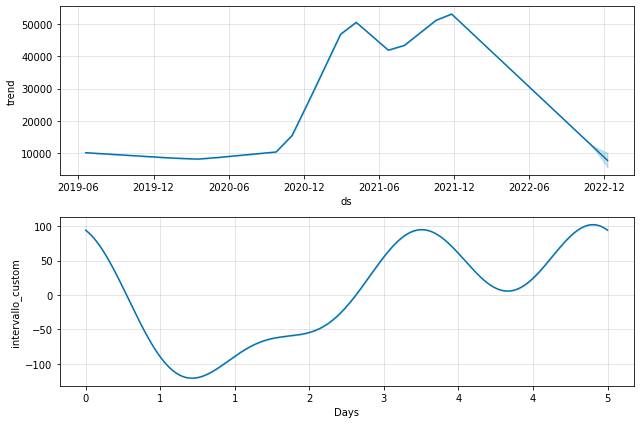

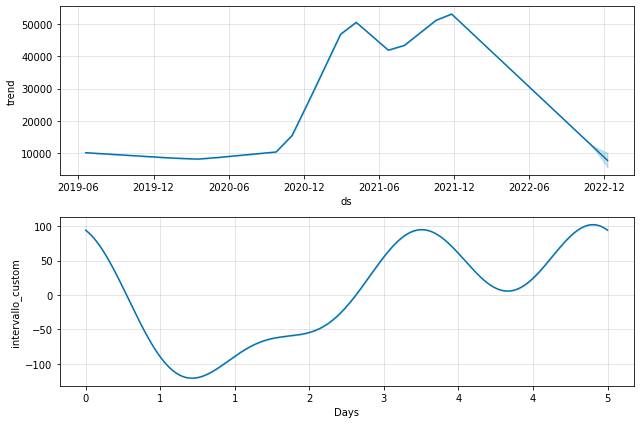

In [38]:
m.plot_components(forecast)

In [39]:
mae_train = np.mean(np.abs(forecast['yhat'].values[:-giorni_previsione] - train_candles.y.values))
mae_test = np.mean(np.abs(forecast['yhat'].values[-giorni_previsione:] - test_candles.y.values))
print('errore medio in valore assoluto in addestramento:', mae_train)
print('errore medio in valore assoluto in test         :', mae_test)

errore medio in valore assoluto in addestramento: 3133.21996784382
errore medio in valore assoluto in test         : 6807.865557163779


In [40]:
from prophet.plot import plot_plotly

plot_plotly(m, forecast)

11:05:12 - cmdstanpy - INFO - Chain [1] start processing
11:05:12 - cmdstanpy - INFO - Chain [1] done processing


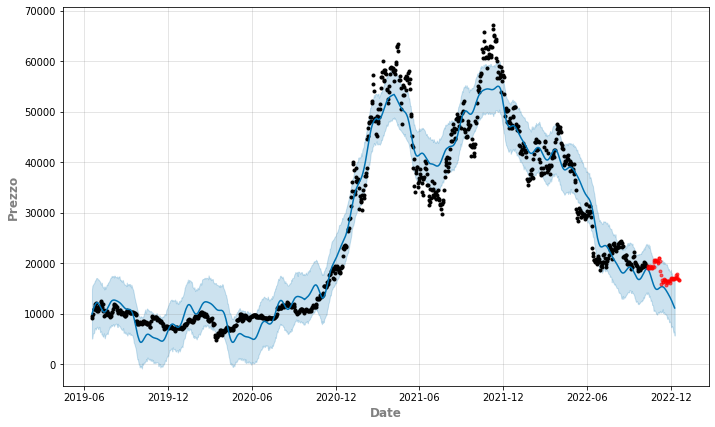

errore medio in valore assoluto in addestramento: 2981.6634325362625
errore medio in valore assoluto in test         : 3047.757988947689


In [41]:
# riapplicazione di Prophet su un periodo custom lungo
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.add_seasonality(
    'intervallo_custom', # nome
    period=200, # giorni del periodo custom
    fourier_order=8, # numero delle componenti della trasformata di Fourier da considerare
    mode='additive'
)

m.fit(train_candles)

future = m.make_future_dataframe(periods=giorni_previsione)
forecast = m.predict(future)

m.plot(forecast)
plt.plot(test_candles.y, '.', color='red', alpha=0.6)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Prezzo', fontsize=12, fontweight='bold', color='gray')
plt.show()

mae_train = np.mean(np.abs(forecast['yhat'].values[:-giorni_previsione] - train_candles.y.values))
mae_test = np.mean(np.abs(forecast['yhat'].values[-giorni_previsione:] - test_candles.y.values))
print('errore medio in valore assoluto in addestramento:', mae_train)
print('errore medio in valore assoluto in test         :', mae_test)

10:47:06 - cmdstanpy - INFO - Chain [1] start processing
10:47:07 - cmdstanpy - INFO - Chain [1] done processing
10:47:08 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:10 - cmdstanpy - INFO - Chain [1] start processing
10:47:11 - cmdstanpy - INFO - Chain [1] done processing
10:47:12 - cmdstanpy - INFO - Chain [1] start processing
10:47:13 - cmdstanpy - INFO - Chain [1] done processing
10:47:14 - cmdstanpy - INFO - Chain [1] start processing
10:47:15 - cmdstanpy - INFO - Chain [1] done processing
10:47:16 - cmdstanpy - INFO - Chain [1] start processing
10:47:17 - cmdstanpy - INFO - Chain [1] done processing
10:47:18 - cmdstanpy - INFO - Chain [1] start processing
10:47:19 - cmdstanpy - INFO - Chain [1] done processing
10:47:20 - cmdstanpy - INFO - Chain [1] start processing
10:47:21 - cmdstanpy - INFO - Chain [1] done processing
10:47:22 - cmdstanpy - INFO - Chain [1] start processing
10:47:23 - cmdstanpy - INFO - Chain [1]

miglior periodo: 455 (in 12 componenti)con mae: 1541.4233037036336


10:48:28 - cmdstanpy - INFO - Chain [1] start processing
10:48:29 - cmdstanpy - INFO - Chain [1] done processing


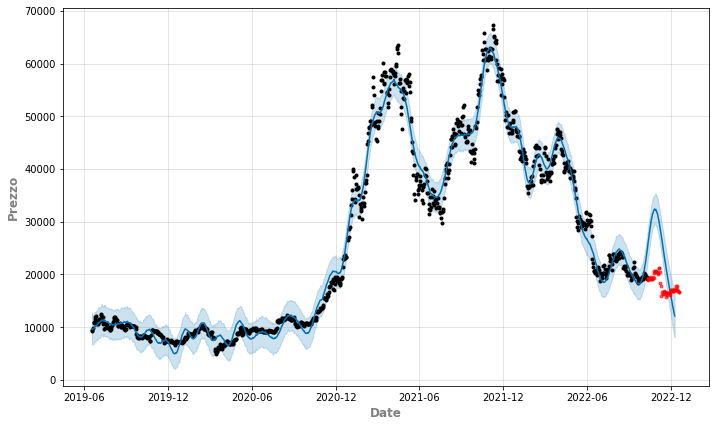

errore medio in valore assoluto in addestramento: 1659.1408546769258
errore medio in valore assoluto in test         : 7607.7962828312675


In [30]:
best_mae = 9e99
best_period = -1
best_fourier_order = -1

for p in range(5, 500, 50):
    for f in range(3, 13, 3):
        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
        m.add_seasonality(
            'intervallo_custom',
            period=p,
            fourier_order=f,
            mode='additive'
        )

        m.fit(train_candles)

        future = m.make_future_dataframe(periods=giorni_previsione)
        forecast = m.predict(future)

        mae_train = np.mean(np.abs(forecast['yhat'].values[:-giorni_previsione] - train_candles.y.values))

        if mae_train < best_mae:
            best_mae = mae_train
            best_period = p
            best_fourier_order = f

print('miglior periodo:', p, '(in', f, 'componenti) con mae:', best_mae)

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.add_seasonality(
    'intervallo_custom',
    period=best_period,
    fourier_order=best_fourier_order,
    mode='additive'
)

m.fit(train_candles)

future = m.make_future_dataframe(periods=giorni_previsione)
forecast = m.predict(future)

m.plot(forecast)
plt.plot(test_candles.y, '.', color='red', alpha=0.6)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Prezzo', fontsize=12, fontweight='bold', color='gray')
plt.show()

mae_train = np.mean(np.abs(forecast['yhat'].values[:-giorni_previsione] - train_candles.y.values))
mae_test = np.mean(np.abs(forecast['yhat'].values[-giorni_previsione:] - test_candles.y.values))
print('errore medio in valore assoluto in addestramento:', mae_train)
print('errore medio in valore assoluto in test         :', mae_test)